<center><font size = "10"> Week 3 - Ion Channels <center>
<center><font size = "8">Home work<center>

<font size = "3">Please, write your group number and the names and surnames of the group members here
<br>Group number: 1
<br>Group member1: Gasser Elbanna
<br>Group member2: Milo Imbeni
<br>Group member3: Louise Placidet

In [43]:
# Importing libraries:

import h5py

# Ex1. Fit data to sigmoid curve

<font size = "3">Fit the data in Sigmoid.dat file located in your group folder. 

<font size = "3">The function of a sigmoid is:
\begin{equation}  
    y = \frac {1}{(1 + e^{(\frac{x - vh}{-slope})})}
\end{equation}
    
<font size = "3">Show the data and the fitted curve on the same plot (as it was done in tutorial 1), label the axes and create a legend to differentiate the data from the fitted curve. Evaluate how well the curve fits the data. [0.5 pts]

In [44]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

def func_sig(x, v_half, slope):
    return 1/(1 + np.exp(-(x-v_half)/slope))

def curveFittingSingleSigmoid(fileName):
    '''This function computes an sigmoid fitting for the data in fileName'''
    # Open the file and separate the columns in x and y
    df = pd.read_table(fileName, sep='\s+', header=None)
    x_data = df[0]
    y_data = df[1]
    
    # In this case, we want to compute v_half = popt[0] and slope = popt[1]
    # and to quantify the fitting quality we want to know perr
    popt, pcov = curve_fit(func_sig, x_data, y_data)
    perr = np.sqrt(np.diag(pcov))
        
    plt.figure(figsize=(10,6))
    print('Error for: ')
    print('V_half error: %.3f'%(perr[0]))
    print('Slope error: %.3f'%(perr[1]))
    plt.plot(x_data, y_data, 'xk', label='original data' )
    plt.plot(x_data, func_sig(x_data, popt[0], popt[1]), '-r',label='fit data: with v_half=%.3f, slope=%.3f' %(popt[0], popt[1]))
    plt.xlabel('Voltage V [mV]')
    plt.ylabel('G/G_max: normalized conductance')
    plt.legend()
    plt.show()

Error for: 
V_half error: 0.128
Slope error: 0.114


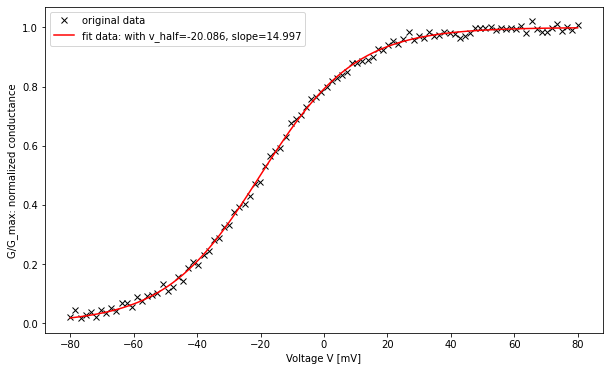

In [45]:
dat_path = 'Group 1/Sigmoid.dat'

curveFittingSingleSigmoid(dat_path)

Using the scipy function curve_fit, we are able to compute the estimated covariance of the fitting.  This enables us to then obtain the standard deviation error for our respective parameters, slope and v_half.  In this case, the errors computed for the slope and v_half are respectively 0.128 and 0.114.

As a result, we have:

v_half = -20.086 +/- 0.128 mV
slope = 14.997 +/- 0.114

# Ex2. Analysing an activation curve.

<font size = "3">Using the .NWB file in your folder group, fit each of the traces between 100 ms and the maximum amplitude of the trace to an exponential, to find the time constant at every voltage step. What does this time constant represent ? Plot the time constants for the activation, considering that the clamped voltage stimulation is between -90 and +80 mV with a 10mV step interval. [2 pts]


In [46]:
def func_exp(x, tau):
    return 1 - np.exp(-x/tau)

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

def analyse_activation_curve(nwbFile, protocolName, repID, plotTraces = False):
    ''' Function .....
    :param nwbFile: the data path to file
    :param protocolName: protocol name defined in the data file
    :param repID: protocol repetition number
    :param byTraces: if true, represent each trace in one figure'''
    
    # Open the file
    open_data = h5py.File(nwbFile, 'r')
    
    # Select on strings what do we want for ploting
    string_data = '/acquisition/timeseries/'+ protocolName + '/repetitions/repetition' + repID +'/data'
    string_xinterval = '/acquisition/timeseries/'+ protocolName + '/repetitions/repetition' + repID +'/x_interval'
    string_xstart = '/acquisition/timeseries/'+ protocolName + '/repetitions/repetition' + repID +'/x_start'
    
    # safe on different variables
    data = open_data[(string_data)].value
    x_interval = open_data[(string_xinterval)].value
    x_start = open_data[(string_xstart)].value

    # create time vector in ms
    nRow, nCol = data.shape
    x_end = x_start[0] + x_interval[0]*(float(nRow - 1))
    time = np.linspace(x_start[0], x_end, nRow)*1000
    
    
    data_t = np.transpose(data)
    i = 0
    
    # For each trace,the tau values is computed as well as the standard deviation
    tau_values = [] # the tau values computed for each trace
    tau_sd = [] # the standard deviation for each of the tau values obtained
    
    for trace in data_t:
        
        # First limit the data and time interval for it to start at 100ms
        time_reduced = time[time >= 100]
        trace_reduced = trace[990:]
        
        # For each trace, the data and time intervals are limited to the maximum avlue of the amplitude of the trace
        time_of_max = time_reduced[np.argmax(trace_reduced)] # time where the amplitude of the trace is maximum
        time_reduced_twice = time_reduced[time_reduced <= time_of_max] # keeping only the time interval before the amplitude max
        trace_reduced_twice = trace_reduced[:np.argmax(trace_reduced)+1] # keeping the trace until it reaches its maximum   
        
        # Fitting exponential curve to it
        popt, pcov = curve_fit(func_exp, time_reduced_twice, trace_reduced_twice)
        perr = np.sqrt(np.diag(pcov)) # standard deviation
        print(popt)
        
        # Adding tau and standard deviation of tau in lists:
        tau_values.append(popt[0])
        tau_sd.append(perr)

        if plotTraces:
            # Plotting to check
            plt.figure()
            plt.title('%s protocol, trace %s' %(protocolName,i))
            plt.ylabel('voltage traces (mV)')
            plt.xlabel('time (ms)')
            plt.plot(time_reduced_twice, trace_reduced_twice, 'b', label='original data')
            plt.plot(time_reduced_twice, func_exp(time_reduced_twice, popt[0]), '-r',label='fit: tau=%.3f, error=%.3f' %(popt[0],perr))

            # plt.axvline(x=time_of_max) # Vertical line indicating where the maximum value is
            i = i + 1
            plt.show()
        
        

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


[1.]


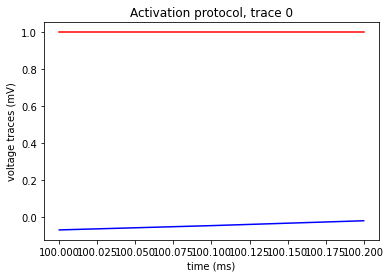

/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


[1.]


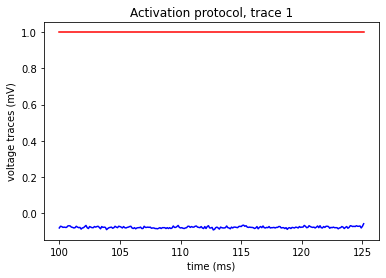

/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


[1.]


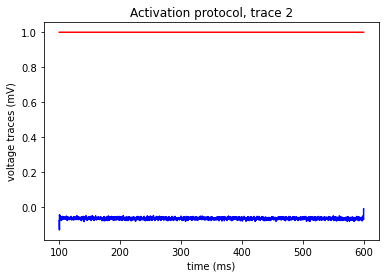

/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


[1.]


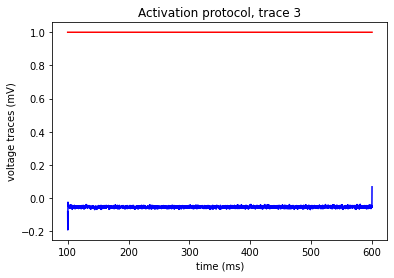

/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


[1.]


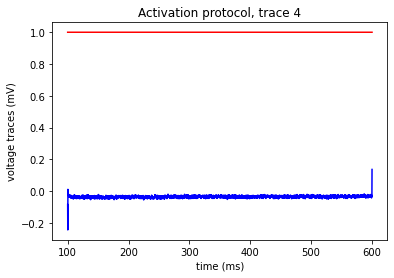

[1.]


/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


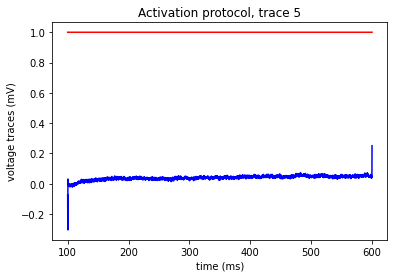

/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


[1.]


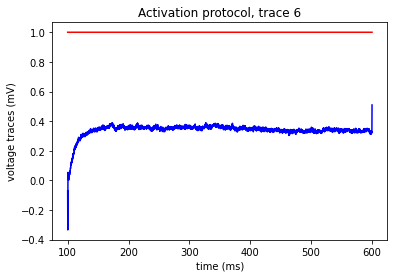

/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


[1.]


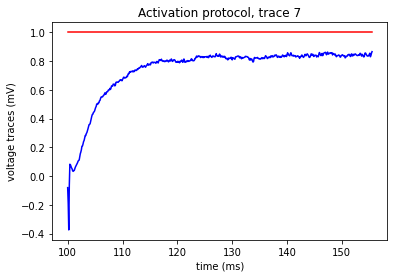

[1.]


/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


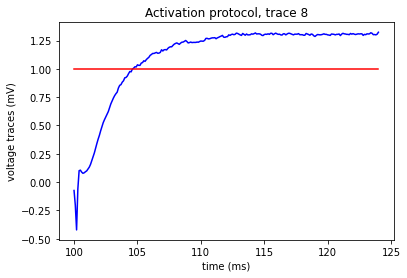

/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


[1.]


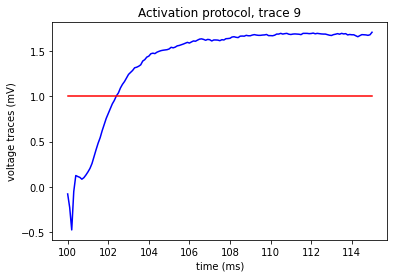

[1.]


/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


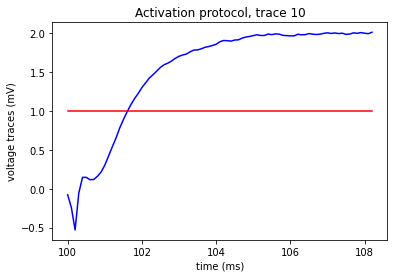

/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


[1.]


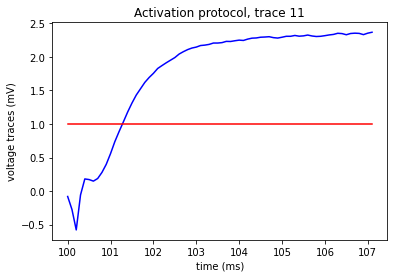

[1.]


/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


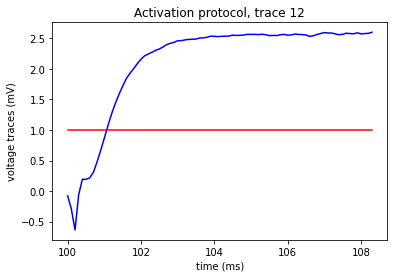

/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


[1.]


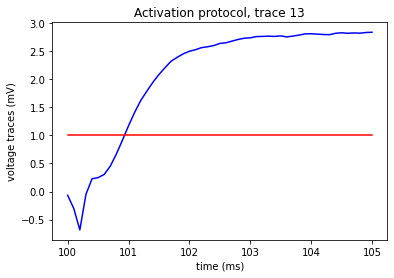

/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


[1.]


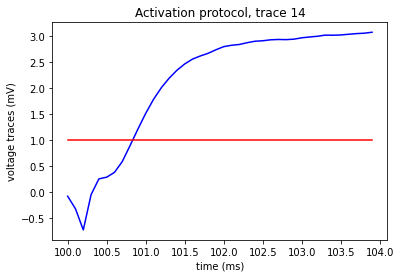

/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


[1.]


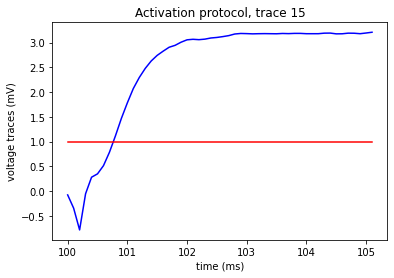

[1.]


/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


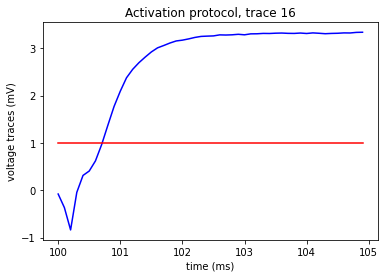

/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


[1.]


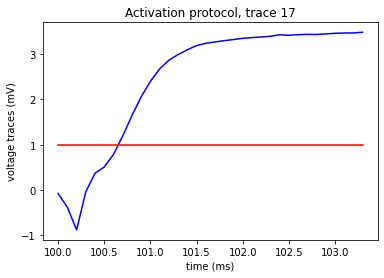

In [48]:
data_path = 'rCell2268.nwb'

analyse_activation_curve(data_path, 'Activation', '2', plotTraces=True)

From the plot above, we plotted the time constant according to the injected voltage.

# Ex3. Find the minimum current amplitude to make the cell fire

<font size = "3">Create a cell in Neuron with the fillowing characteristics: 1 section (soma) with one segment, 15 µm of length and diameter, 120 Ω*cm of axial radius and 1.6 µF/cm^2 of capacitance. Add passive and active (gNa = 0.1 S and gK = 0.015 S) membrane properties to this cell. Generate a current clamp experiment in which you will inject a current into the cell soma with 50 ms delay, 500 ms of duration. The total recording duration of the experiment would be 800 ms and the voltage base -70 mV. Find the minimum amount of current that has to be injected in this cell in order to make it fire (an automated way of finding this value is an option). What is the threshold membrane voltage? How do the rheobase and theshold voltage change when the membrane properties are changed?
    
<font size = "3">Keep in mind that square current pulses are not biologically realistic. Discuss why finding the minimum amount of current that makes a neuron fire could be interesting to study the cell. [1 pt]

In [49]:
from neuron import h

# Create a section 
soma = h.Section()
soma.L = 15.0     # length (µm)
soma.diam = 15.0  # diameter (µm)
soma.Ra = 120.0   # axial resistivity (Ω*cm)
soma.cm = 1.6       # capacitance (µF/cm^2) 

# Insert passive properties
soma.insert('pas')
for seg in soma:
    seg.pas.g = 0.0003 # Conductance of the leak channels (in S/cm2)
    seg.pas.e = -70   # Leak reversal potential, it influences the steady state membrane potential

# Insert active properties
soma.insert('hh')
for seg in soma:
    seg.hh.gkbar = 0.015   # Maximal conductance of the potassium channels
    seg.hh.gnabar = 0.1  # Maximal conductance of the sodium channels


Threshold Voltage for I_amp = 0.014614: 
-54.09193522176705


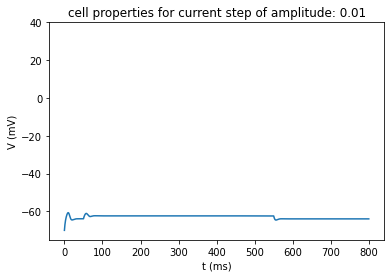

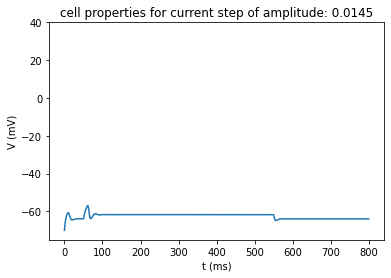

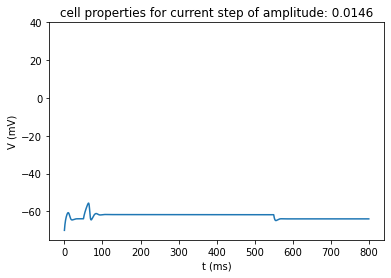

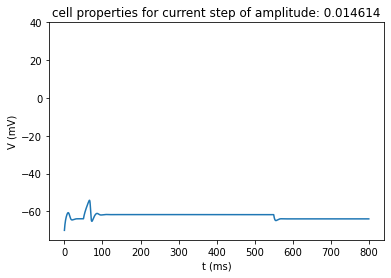

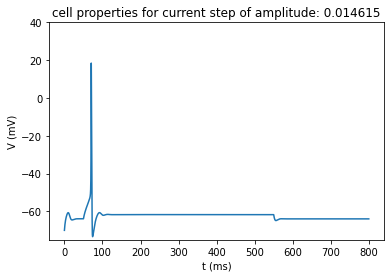

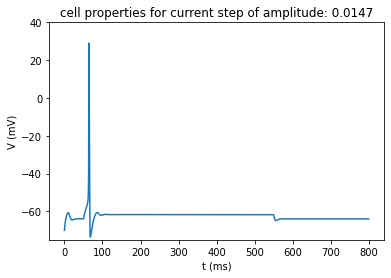

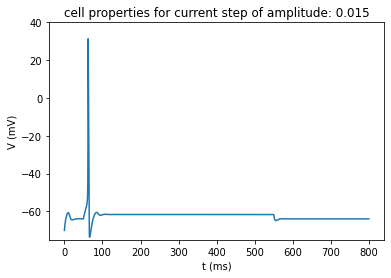

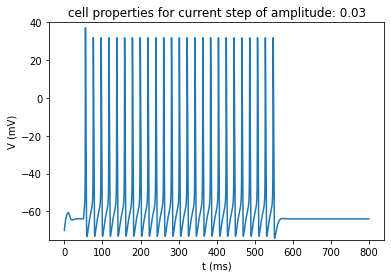

In [87]:
# Inject a current step into the soma
stim = h.IClamp(soma(0.5))         # Place a stimulation electrode in the middle of the soma
stim.delay = 50   # stim delay (ms)
stim.dur = 500     # stim duration (ms)

I_amp_values = [0.01, 0.0145, 0.0146, 0.014614, 0.014615, 0.0147, 0.015, 0.03]

for I_amp in I_amp_values:
    stim.amp = I_amp     # stim amplitude (pA)

    # Initialize NEURON vectors to record time, voltage and current
    # time vector
    rec_t = h.Vector()
    rec_t.record(h._ref_t)
    # membrame potential vector
    rec_v = h.Vector()
    rec_v.record(soma(0.5)._ref_v)
    # current
    rec_i = h.Vector()
    rec_i.record(stim._ref_i)

    # Initialize and run a simulation
    h.load_file('stdrun.hoc')
    h.finitialize(-70)
    h.continuerun(800)
    
    if I_amp == 0.014614:
        print("Threshold Voltage for I_amp = 0.014614: ")
        print(rec_v.max())
        
    # PLOT 
    plt.figure()
    plt.title('cell properties for current step of amplitude: '+str(I_amp))
    plt.ylim([-75, 40])
    plt.ylabel('V (mV)')
    plt.xlabel('t (ms)')
    plt.plot(rec_t,rec_v)


Find the minimum amount of current that has to be injected in this cell in order to make it fire (an automated way of finding this value is an option). What is the threshold membrane voltage? How do the rheobase and theshold voltage change when the membrane properties are changed?

Keep in mind that square current pulses are not biologically realistic. Discuss why finding the minimum amount of current that makes a neuron fire could be interesting to study the cell. [1 pt]

According to the graphs above, by testing out several values using a for loop, we identified the minimum amount of current ot inject in order to make it fire: 0.014615 pA

# WE NEED TO DISCUSS WHAT I SAY BELOW, AND WHAT I PLOT UNDERNEATH
The threshold membrane voltage is the threshold value that the membrane potential has to reach in order for it to trigger an action potential.  To compute it, we can evaluate the maximum voltage amplitude when we inject current just under the current limit where the action potentials are triggered.  As a result, when injecting 0.014614 pA, we measure the maximum voltage amplitude at: -54.091935 mV

# ANSWER IN A BETTER WAY THE FOLLOWING: How do the rheobase and theshold voltage change when the membrane properties are changed?

There is no strict threshold voltage, and it varies strongly wiht the type of stimulus used, the membrane resistance and capacitance:
In the code below, we keep the injected current's amplitude constant, but we modify the resistance and capacitance

0.006
0.6
1.6
2.6


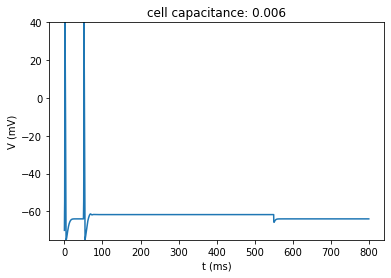

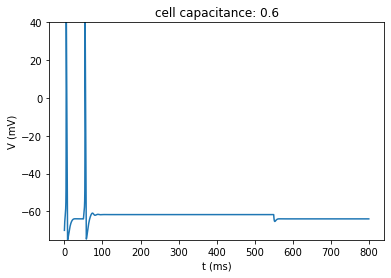

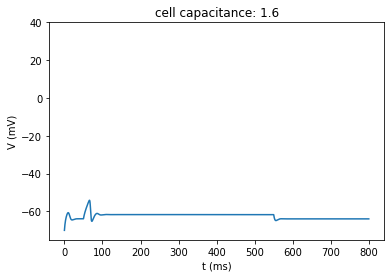

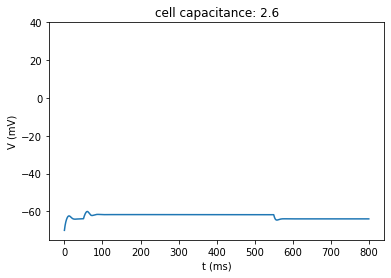

In [103]:
from neuron import h

#R_values = [0.000000001, 120.0, 2000000000.0]
C_values = [0.6, 1.6, 2.6]


#for resistance in R_values:
for capacitance in C_values:
    print(capacitance)
    
    # Create a section 
    soma = h.Section()
    soma.L = 15.0     # length (µm)
    soma.diam = 15.0  # diameter (µm)
#    soma.Ra = resistance   # axial resistivity (Ω*cm)
    soma.Ra = 120.0   # axial resistivity (Ω*cm)
    soma.cm = capacitance       # capacitance (µF/cm^2) 

    # Insert passive properties
    soma.insert('pas')
    for seg in soma:
        seg.pas.g = 0.0003 # Conductance of the leak channels (in S/cm2)
        seg.pas.e = -70   # Leak reversal potential, it influences the steady state membrane potential

    # Insert active properties
    soma.insert('hh')
    for seg in soma:
        seg.hh.gkbar = 0.015   # Maximal conductance of the potassium channels
        seg.hh.gnabar = 0.1  # Maximal conductance of the sodium channels

    # Inject a current step into the soma
    stim = h.IClamp(soma(0.5))         # Place a stimulation electrode in the middle of the soma
    stim.delay = 50   # stim delay (ms)
    stim.dur = 500     # stim duration (ms)
    stim.amp = 0.014614     # stim amplitude (pA)


    # Initialize NEURON vectors to record time, voltage and current
    # time vector
    rec_t = h.Vector()
    rec_t.record(h._ref_t)
    # membrame potential vector
    rec_v = h.Vector()
    rec_v.record(soma(0.5)._ref_v)
    # current
    rec_i = h.Vector()
    rec_i.record(stim._ref_i)

    # Initialize and run a simulation
    h.load_file('stdrun.hoc')
    h.finitialize(-70)
    h.continuerun(800)
        
    # PLOT 
    plt.figure()
#    plt.title('cell axial resistivity: '+str(resistance))
    plt.title('cell capacitance: '+str(capacitance))
    plt.ylim([-75, 40])
    plt.ylabel('V (mV)')
    plt.xlabel('t (ms)')
    plt.plot(rec_t,rec_v)


# VERIFY CONCLUSIONS WITH TEAM COCO POPS
When modifying the axial resistivity, no big changes were noted.

When decreasing the cell's capacitance, one could note that when it would decrease the amount of action potentials trigerred was increased.

Finding the minimum amount of current that makes the neuron fire is interesting to study the cell, because it enables us to study the dynamics which trigger the generation of an action potential, and how it is influenced by outside conditions and membrane properties.  It can therefore give us potential insights to better understand the mechanisms in both physiological and pathological conditions.

# Ex4. Modifing K+ channel kinetics

<font size = "3">Create a cell in Neuron with the following characteristics: 1 section (soma) with one segment, 17.0 µm of length and diameter, 122 Ω*cm of axial radious and 1.2 µF/cm^2 of capacitance. Add passive and active (gNa = 0.09 S and gK = 0.01 S) membrane properties to this cell. Generate a current clamp experiment in which you will inject a current into the cell soma with 150 ms delay, 600 ms of duration. The total recording duration of the experiment would be 1000 ms and the voltage base -70 mV. 

<font size = "3">Increase and decrase the v_half parameter on the mod file with the K+ channel kinetics. Plot the resulting voltage curves and the I-V and tau-V curves. 

<font size = "3">Explain what is going on. What is the meaning of v_half? Why does changing this parameter affect the resultant action potential? [2.5 pts]